In [16]:
# Do necessary imports
import numpy as np
from matplotlib import pyplot as plt

# For the Earth, Sun, Jupiter 3-body Problem:

# Masses of the Planets
Me = 6e24                     # Mass of Earth in kg
Ms = 2e30                     # Mass of Sun in kg                       
Mj = 200*1.89813e27               # Mass of Jupiter in kg

# Initial Positions of the Planets (vectors)
Re = np.array([1.496e11*1,0,0]) #1 AU away from the sun converted to m
Rs = np.array([0,0,0])
Rj = np.array([1.496e11*5.2,0,0]) #5.2 AU away from the sun converted to m

# Initial Velocity of the Planets (vectors)
# currently random numbers to see if code runs
Ve = np.array([0,30e3,0])
Vs = np.array([0,0,0])
Vj = np.array([0,13.06e3,0])


u_0 = np.array([Re[0], Re[1], Re[2],
                Rs[0], Rs[1], Rs[2],
                Rj[0], Rj[1], Rj[2],
                Ve[0], Ve[1], Ve[2],
                Vs[0], Vs[1], Vs[2],
                Vj[0], Vj[1], Vj[2]])

G = 6.673e-11                 # Gravitational Constant



# Calculate the gravitional force on a body given the position vectors and the masses of the bodies
# ====================================================================================================================

def Gravitational_Force(ri, rj, mi, mj, G=6.673e-11):
    return ((G*mi*mj*(np.array(rj)-np.array(ri)))/(np.linalg.norm(np.array(rj)-np.array(ri)))**3)

def force(planet, Re, Rs, Rj):
    force_sun_on_earth = Gravitational_Force(Re,Rs,Me,Ms)
    force_earth_on_sun = -force_sun_on_earth
    force_jupiter_on_earth = Gravitational_Force(Re,Rj,Me,Mj)
    force_earth_on_jupiter = -force_jupiter_on_earth
    force_sun_on_jupiter = Gravitational_Force(Rj,Rs,Mj,Ms)
    force_jupiter_on_sun = -force_sun_on_jupiter
    
    if planet == "earth":
        return force_sun_on_earth + force_jupiter_on_earth
    if planet == "sun":
        return force_earth_on_sun + force_jupiter_on_sun
    if planet == "jupiter":
        return force_sun_on_jupiter + force_earth_on_jupiter
    
def acc_planet(planet,Re,Rs,Rj,M):
    a = force(planet, Re, Rs, Rj)/M
    return a
    
def f_true(u):
    Re = [u[0], u[1], u[2]]
    Rs = [u[3], u[4], u[5]]
    Rj = [u[6], u[7], u[8]]

    a_earth = acc_planet('earth',Re,Rs,Rj,Me)
    a_sun = acc_planet('sun',Re,Rs,Rj,Ms)
    a_jupiter = acc_planet('jupiter',Re,Rs,Rj,Mj)
    

    udot = np.array([u[9], u[10], u[11],
                     u[12], u[13], u[14],
                     u[15], u[16], u[17],
                     a_earth[0], a_earth[1], a_earth[2],
                     a_sun[0], a_sun[1], a_sun[2], 
                     a_jupiter[0], a_jupiter[1], a_jupiter[2]])
    
    return udot

# IVP Forward Euler Code
import numpy as np

def ivp_forward_euler(u_0, T, delta_t):
    """Returns the predicted system evolution over time using the forward Euler method.

    This function assumes an f_true(u) function is globally available for calculating the true function value at u.
    
    Parameters
    ----------
    u_0 : array
        1 x N array defining the initial state vector u_0 where N = number of state variables = |u|
    T : float_like
        Final time T
    delta_t : float_like
        Time step size where delta_t = t_{k+1} - t_k
        
    Returns
    -------
    u : array
        K x N array of the predicted states where row k is the state at time step k and K = number of time steps
    times : array_like
        Length K vector containing the times t corresponding to time steps
    """
    

    times = np.arange(0, T+delta_t,delta_t)
    u = np.zeros((len(times),len(u_0)))
    for i in range(len(times)):
        if i == 0:
            u[0] = u_0
        else:  
            u[i] = u[i-1] + delta_t*f_true(u[i-1])
    
    return u, times

In [17]:
def runge_kutta(u_k, delta_t):
    y1 = f_true(u_k)
    y2 = f_true(u_k + (1/2)*delta_t*y1)
    y3 = f_true(u_k + (1/2)*delta_t*y2)
    y4 = f_true(u_k + delta_t*y3)
    u_kplus1 = u_k + (1/6)*delta_t*(y1 + 2*y2 + 2*y3 + y4)
    return u_kplus1

import numpy as np
def ivp_abm3(u_0, T, delta_t):
    """Returns the predicted system evolution over time using the 2-step Adams-Bashforth method.

    This function assumes an f_true(u) function is globally available for calculating the true function value at u.
    
    Parameters
    ----------
    u_0 : array
        1 x N array defining the initial state vector u_0 where N = number of state variables = |u|
    T : float_like
        Final time T
    delta_t : float_like
        Time step size where delta_t = t_{k+1} - t_k
        
    Returns
    -------
    u : array
        K x N array of the predicted states where row k is the state at time step k and K = number of time steps
    times : array_like
        Length K vector containing the times t corresponding to time steps
    """
    
    ### YOUR CODE HERE ###
    times = np.arange(0,T+delta_t,delta_t)
    u = np.zeros((len(times),len(u_0)))
    for i in range(len(times)):
        if i == 0:
            u[0] = u_0
        elif i == 1:
            u[1] = runge_kutta(u[0], delta_t)
        elif i == 2:
            u[2] = runge_kutta(u[1], delta_t)
        else :
            #Adams-Bashforth Predictor
            u[i] = delta_t/12 * (5*f_true(u[i-3]) - 16*f_true(u[i-2]) + 23*f_true(u[i-1])) + u[i-1]
            #Admas-Moulton Corrector
            u[i] = u[i-1] + delta_t/24 * (f_true(u[i-3]) - 5*f_true(u[i-2]) + 19*f_true(u[i-1]) + 9*f_true(u[i]))
    return u, times

def ivp_abm3_error(u_0, T, delta_t):
    """Returns the error in the predicted final system state when using delta_t relative to delta_t_baseline for the 2-step Adams Bashforth method.

    This function assumes an f_true(u) function is globally available for calculating the true function value at u.
    
    Parameters
    ----------
    u_0 : array
        1 x N array defining the initial state vector u_0 where N = number of state variables = |u|
    T : float_like
        Final time T
    delta_t : float_like
        Time step size where delta_t = t_{k+1} - t_k
    delta_t_basleine : float_like
        Baseline time step size where delta_t_baseline = t_{k+1} - t_k
        
    Returns
    -------
    err : float
        Error calculated as ||u_final_delta_t - u_final_delta_t_baseline|| / ||u_final_delta_t_baseline||, where u_final_delta_t is the final predicted state when using delta_t
    """
    
    ### YOUR CODE HERE ###
    u_abm3, times_abm3 = ivp_abm3(u_0, T, delta_t)
    u_t_abm3_final = u_abm3[-1]
    # predict final state using delta_t_baseline
    u, times = analytical(u_0, T, delta_t, ax, ay)
    u_t_analytical_final = u[-1]
    # calculate error
    e = np.linalg.norm(u_t_abm3_final - u_t_analytical_final)/np.linalg.norm(u_t_analytical_final)
    return e

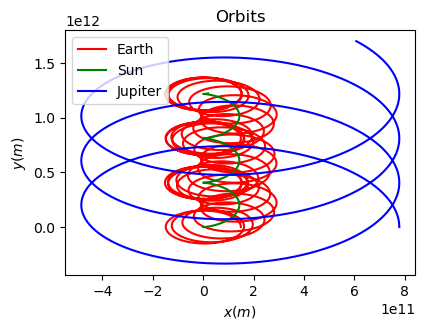

In [3]:
import matplotlib.pyplot as plt
plt.style.use('default')

delta_t = 86400
fig1 = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = fig1.add_subplot(221)

u, times = ivp_abm3(u_0, 9.5e8, 86400)

# print(u)

ax1.plot(u[:,0],u[:,1],"r", label = "Earth")
ax1.plot(u[:,3],u[:,4],"g", label = "Sun")
ax1.plot(u[:,6],u[:,7],"b", label = "Jupiter")

ax1.set_title("Orbits")
ax1.set_xlabel("$x(m)$")
ax1.set_ylabel("$y(m)$")
ax1.legend()

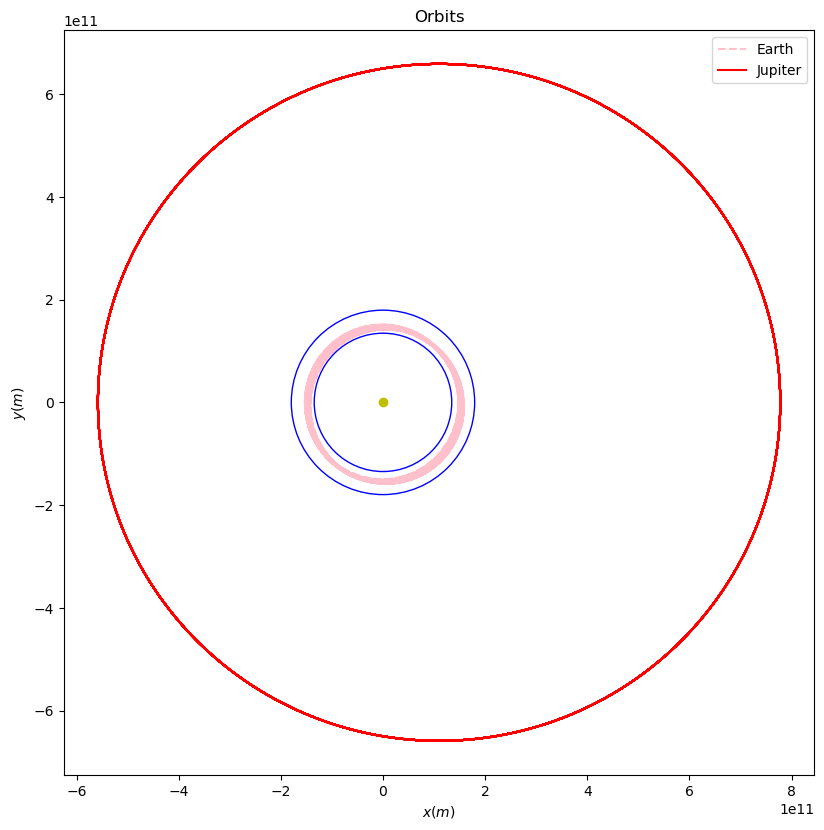

In [18]:
import matplotlib.pyplot as plt
plt.style.use('default')

delta_t = 86400
fig1 = plt.figure(figsize=(16, 16), tight_layout=True)
ax1 = fig1.add_subplot(221)

u, times = ivp_abm3(u_0, 3.784e9, 86400)

# print(u)



ax1.plot(u[:,0]-u[:,3],u[:,1]-u[:,4],"pink",linestyle = "--", label = "Earth")
#ax1.plot(0,0,"g", label = "Sun")
ax1.plot(0,0,'o', color = "y")
ax1.plot(u[:,6]-u[:,3],u[:,7]-u[:,4],"r", label = "Jupiter")

innercircle = plt.Circle((0,0), radius = 1.496e11*0.9, fill = False, color = "blue")
outercircle = plt.Circle((0,0), radius = 1.496e11*1.2, fill = False, color = "blue")
ax1.add_patch(innercircle)
ax1.add_patch(outercircle)

ax1.set_title("Orbits")
ax1.set_xlabel("$x(m)$")
ax1.set_ylabel("$y(m)$")
ax1.legend()

ValueError: Invalid RGBA argument: 'g--'

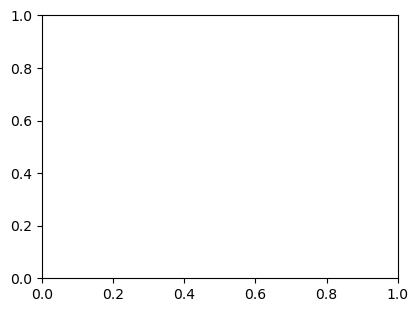

In [5]:
import matplotlib.pyplot as plt
plt.style.use('default')

delta_t = 86400
fig1 = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = fig1.add_subplot(221)


# print(u)
innercircle = plt.Circle((0,0), radius = 0.6, fill = False, color = "g--")
outercircle = plt.Circle((0,0), radius = 0.3, fill = False, color = "pink")
ax1.add_patch(innercircle)
ax1.add_patch(outercircle)
